In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.stats import skew
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import pandas as pd
import numpy as np
import sklearn
import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
import lightgbm as lgb
import re
import string
import codecs
import os
import nltk
from nltk import FreqDist
from nltk.collocations import *
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import wordnet
from nltk.util import bigrams
from collections import defaultdict
import collections
import xgboost
from sklearn.cross_validation import KFold

In [71]:
#path
path='/home1/shivang.sharma/to_gpu'

In [72]:
df_train=pd.read_csv(path+'/'+'train.csv')
df_campaign=pd.read_csv(path+'/'+'campaign_data.csv')
df_test=pd.read_csv(path+'/'+'test.csv')

In [73]:
df_train.columns

Index(['id', 'user_id', 'campaign_id', 'send_date', 'is_open', 'is_click'], dtype='object')

In [74]:
df_test.columns

Index(['id', 'campaign_id', 'user_id', 'send_date'], dtype='object')

In [75]:
def corr_2_cols(df,col1,col2):
    res=df.groupby([col1,col2]).size().unstack()
    res['perc']=(res[res.columns[1]]/(res[res.columns[0]]+res[res.columns[1]]))*100
    res=res.sort_values(by='perc',ascending=False)
    return res


In [76]:
ENG_STOP_WORDS = nltk.corpus.stopwords.words('english')
filter_list=['dear','hi','avians']

def tokenize(text):
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    return tokens

def stem(tokens):
    stemmer = SnowballStemmer("english")
    stems = [stemmer.stem(t) for t in tokens]
    return stems

def remove_common_words(tokens):

    clean_token_list = []

    for token in tokens:
        if token.lower() not in ENG_STOP_WORDS:
            clean_token_list.append(token.lower())

    return clean_token_list

def lower(tokens):
    tokens = [t.lower() for t in tokens]
    return tokens

def clean_up_text(query):
    # Strip of tags from text using Beautiful Soup
    soup = BeautifulSoup(query, 'lxml')
    soup = soup.get_text()
    soup = soup.strip('\n').strip("\t").strip("\r").replace("\n", " ").replace("\t", " ").replace("\r", " ")
    return soup

def clean(mail):
    clean_query=mail.lower()
    clean_query = re.sub(r'\.+', ". ",mail)
    clean_query = re.sub('([.,!#?()=<>*/&}~^@|{])', r' \1 ', clean_query)
    clean_query = re.sub(r'\s{2,}', r' ', clean_query)
    clean_query = clean_up_text(clean_query)
    return clean_query


def filter_(tokens,filter_list):
    filtered = [token for token in tokens if token not in filter_list]
    pattern = '\d+'
    #replace numbers with empty string
    text = re.sub(pattern, "", " ".join(filtered))
    return text.split(" ")

def preprocessing(text):
    text1=clean(text)
    tokens=tokenize(text1)
    tokens=lower(tokens)
    tokens=filter_(tokens,filter_list)
    tokens=remove_common_words(tokens)
    tokens=stem(tokens)
    clean_text=' '.join(tokens)
    return clean_text

In [77]:
def clean_text_columns(df1):
    df=df1.copy()

    df['clean_subject']=df['subject'].apply(lambda x:preprocessing(x))
    df['clean_email']=df['email_body'].apply(lambda x:preprocessing(x))

    return df


In [78]:
def subject_line(df1):
    df=df1.copy()
    df['len_subject']=df['clean_subject'].str.len()
    df['capitals'] = df['subject'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
    df['caps_vs_length'] = df.apply(lambda row: float(row['capitals'])/float(row['len_subject']),
                                    axis=1)
    df['num_exclamation_marks'] = df['subject'].apply(lambda comment: comment.count('!'))
    df['num_question_marks'] = df['subject'].apply(lambda comment: comment.count('?'))
    df['ML'] = df['subject'].apply(lambda comment: comment.count('Machine Learning'))
    df['hacks'] = df['subject'].apply(lambda comment: sum(comment.count(w) for w in ('Hackathon', 'DataHack','Hackathons')))
    df['AI'] = df['subject'].apply(lambda comment: comment.count('A.I.'))
    df['num_punctuation'] = df['subject'].apply(
        lambda comment: sum(comment.count(w) for w in '.,;:'))
    df['num_symbols'] = df['subject'].apply(
       lambda comment: sum(comment.count(w) for w in '*&$%'))
    df['num_words'] = df['subject'].apply(lambda comment: len(comment.split()))
    df['num_unique_words'] = df['subject'].apply(lambda comment: len(set(w for w in comment.split())))
    df['words_vs_unique'] = df['num_unique_words'] / df['num_words']
    
    for i,row in df.iterrows():
        if re.match(r'[[a-zA-Z]*]',row['subject'].lower()):
            df.loc[i,'highlighter']=1
        else:
            df.loc[i,'highlighter']=0

        if re.search(r'\binr|win|rs|prizes|prize\b',row['subject'].lower()):
            df.loc[i,'prize_money']=1

        else:
            df.loc[i,'prize_money']=0

    return df


In [79]:
def email_body(df1):
    df=df1.copy()
    df['len_email']=df['clean_email'].str.len()
    df['total_length_b'] = df['email_body'].apply(len)
    df['capitals_b'] = df['email_body'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
    df['caps_vs_length_b'] = df.apply(lambda row: float(row['capitals_b'])/float(row['total_length_b']),
                                    axis=1)
    df['num_exclamation_marks_b'] = df['email_body'].apply(lambda comment: comment.count('!'))
    df['num_question_marks_b'] = df['email_body'].apply(lambda comment: comment.count('?'))
    df['ML_b'] = df['email_body'].apply(lambda comment: comment.count('Machine Learning'))
    df['hacks_b'] = df['email_body'].apply(
        lambda comment: sum(comment.count(w) for w in ('Hackathon', 'DataHack','Hackathons')))
    df['AI_b'] = df['email_body'].apply(lambda comment: comment.count('A.I.'))
    df['num_punctuation_b'] = df['email_body'].apply(
        lambda comment: sum(comment.count(w) for w in '.,;:'))
    df['num_symbols_b'] = df['email_body'].apply(
        lambda comment: sum(comment.count(w) for w in '*&$%'))
    df['num_words_b'] = df['email_body'].apply(lambda comment: len(comment.split()))
    df['num_unique_words_b'] = df['email_body'].apply(
        lambda comment: len(set(w for w in comment.split())))
    df['words_vs_unique_b'] = df['num_unique_words_b'] / df['num_words_b']

    return df


In [80]:
def tfidf(df_train1,df_test1,col):
    
    df_train=df_train1.copy()
    df_test=df_test1.copy()
    
#    print('df_train:',df_train.columns)
    df_train[col].fillna('text na',inplace=True)
    df_test[col].fillna('text na',inplace=True)

    train=list(df_train[col])

    test=list(df_test[col])

    if col=='clean_subject':
        vect=TfidfVectorizer(stop_words='english',max_df=0.95,ngram_range=(1,3))
    else:
        vect=TfidfVectorizer(stop_words='english',max_df=0.95,ngram_range=(1,1))

    #learn the vocabulary of the training data(occurs inplace)
    vect.fit(train)

    #examine the fitted vocabulary
#    vect.get_feature_names()

    #transform data into a document term matrix
    train_dtm=vect.transform(train)
    test_dtm=vect.transform(test)

    df_train_tf_idf=pd.DataFrame(train_dtm.toarray(),columns=vect.get_feature_names())
    
    df_train_tf_idf.columns=['{}_{}'.format(a,col[-1]) for a in df_train_tf_idf.columns]
    
    df_test_tf_idf=pd.DataFrame(test_dtm.toarray(),columns=vect.get_feature_names())
    
    df_test_tf_idf.columns=['{}_{}'.format(a,col[-1]) for a in df_test_tf_idf.columns]
    
    #print('df_test_tf_idf.head:',df_test_tf_idf.head(10))

    df_train_2=pd.concat([df_train,df_train_tf_idf],axis=1)
    df_test_2=pd.concat([df_test,df_test_tf_idf],axis=1)
#     print('df_test_2.head:',df_test_2.head(10))
#
#    print('df_test_2.shape:',df_test_2.shape)

    return df_train_2,df_test_2


In [81]:
def create_dummies(df1,col):
    df=df1.copy()

    df1=pd.get_dummies(df[col])
    df=pd.concat([df,df1],axis=1)
#     df=df.drop(col,axis=1)
    
    return df


In [82]:
def user_patterns(df1):
    
    df=df1.copy()
    
    df_user_pattern=df.groupby('user_id').agg({'is_open':['count','sum'],'is_click':'sum'}).reset_index()
    print(df_user_pattern.head())
    df_user_pattern.columns=df_user_pattern.columns.get_level_values(0)
    df_user_pattern.columns=['user_id','user_id_count','is_open','is_click']
#     df_user_pattern=df_user_pattern.drop('index',axis=1)

#     print(df_user_pattern.head())

    df_user_pattern['open_rate_user']=np.divide(df_user_pattern['is_open'],df_user_pattern['user_id_count'])
    df_user_pattern['click_rate_if_opened_user']=df_user_pattern.apply(lambda x:np.divide(x['is_click'],x['is_open']) if x['is_open']>0 else 0,axis=1)
    df_user_pattern['click_rate_user']=np.divide(df_user_pattern['is_click'],df_user_pattern['user_id_count'])

#    print(df_user_pattern.head())
    
    df_user_pattern_2=df_user_pattern[['user_id','open_rate_user','click_rate_if_opened_user','click_rate_user']]
#    print(df_user_pattern_2.head())

    return df_user_pattern_2


In [83]:
def commun_patterns(df1):
    
    df=df1.copy()
    
    df_commun_pattern=df.groupby('communication_type').agg({'is_open':['count','sum'],'is_click':'sum'}).reset_index()
    print(df_commun_pattern.head())
    df_commun_pattern.columns=df_commun_pattern.columns.get_level_values(0)
    df_commun_pattern.columns=['communication_type','communication_type_count','is_open','is_click']
#     df_commun_pattern=df_commun_pattern.drop('index',axis=1)

#     print(df_user_pattern.head())

    df_commun_pattern['open_rate_commun']=np.divide(df_commun_pattern['is_open'],df_commun_pattern['communication_type_count'])
    df_commun_pattern['click_rate_if_opened_commun']=df_commun_pattern.apply(lambda x:np.divide(x['is_click'],x['is_open']) if x['is_open']>0 else 0,axis=1)
    df_commun_pattern['click_rate_commun']=np.divide(df_commun_pattern['is_click'],df_commun_pattern['communication_type_count'])

#    print(df_user_pattern.head())
    
    df_commun_pattern_2=df_commun_pattern[['communication_type','open_rate_commun','click_rate_if_opened_commun','click_rate_commun']]
#    print(df_user_pattern_2.head())

    return df_commun_pattern_2


In [84]:
def time_variables(df1):
    df=df1.copy()
    df['send_date_2']=pd.to_datetime(df['send_date'],dayfirst=True)
    df['hour_var']=df['send_date_2'].dt.hour
    df['month_var']=df['send_date_2'].dt.month

    df.loc[(df['hour_var']>=10)&(df['hour_var']<=18),'office_hours']=1
    df.loc[(df['hour_var']<10)|(df['hour_var']>18),'office_hours']=0

    df['day_of_week']=df['send_date_2'].dt.weekday
    
    df['day_of_week']=df['day_of_week'].map({0:'monday_week',1:'tuesday_week',2:'wednesday_week',3:'thursday_week',
                                          4:'friday_week',5:'saturday_week',6:'sunday_week'
                                         })

    #df['weekend_var']=df['day_of_week'].apply(lambda x:1 if x>4 else 0)
    
    df=create_dummies(df,'day_of_week')

    df=df.drop(['send_date_2','send_date'],axis=1)

    return df


In [85]:
def day_of_week_pattern(df1):
    df=df1.copy()
    g1 = df.groupby('day_of_week')['is_click'].sum().reset_index()
    g1['dow_click_rate'] = g1['is_click']/df.groupby('day_of_week')['is_click'].count().reset_index(drop=True)
    
    g1=g1[['day_of_week','dow_click_rate']]
    
    return g1
    

In [86]:
def interactive_features(df1):
    df=df1.copy()
    df['internal_link_percent'] = df['no_of_internal_links']/df['total_links']
    df['image_per_section'] = df['no_of_images']/df['no_of_sections']
    df['image_to_links'] = df['no_of_images']/df['total_links']
    df['link_per_section'] = df['total_links']/df['no_of_sections']
    df['image_per_internal'] = df['no_of_images']/df['no_of_internal_links']
    df['int_link_per_section'] = df['total_links']/df['no_of_sections']
    df['section_size'] = df['no_of_sections']/df['len_email']
    df['sub_to_body'] = df['len_subject']/ df['len_email']
    
    return df

In [87]:
def campaign_file_processing(df1,cmp_id=54,cmp_id_2=80):
    df=df1.copy()
    df=create_dummies(df,'communication_type')
    
#     df.drop('communication_type',axis=1,inplace=True)

    df_train=df.loc[df['campaign_id']<=cmp_id,:].reset_index(drop=True)
    df_test=df.loc[(df['campaign_id']>cmp_id)&(df['campaign_id']<=cmp_id_2),:].reset_index(drop=True)
    
#    print(df_test.shape)


    df_train_v2=clean_text_columns(df_train)
    df_test_v2=clean_text_columns(df_test)
    
#    print(df_train_v2.columns)
#    print(df_test_v2.columns)
    
    
    df_train_v4,df_test_v4=tfidf(df_train_v2,df_test_v2,'clean_subject')
    df_train_v5=subject_line(df_train_v4)
    df_test_v5=subject_line(df_test_v4)
#    print('df_test_v5:',df_test_v5.shape)

    df_train_v6,df_test_v6=tfidf(df_train_v5,df_test_v5,'clean_email')

#    print('df_test_v6:',df_test_v6.shape)
    
    
#     print('df_train_v6:',list(df_train_v6.columns))
    
    df_train_v7=email_body(df_train_v6)
    df_test_v7=email_body(df_test_v6)
    
    df_train_v8=interactive_features(df_train_v7)
    df_test_v8=interactive_features(df_test_v7)
    

    df_train_isopen=df_train_v5.drop(['total_links', 'no_of_internal_links', 'no_of_images', 'no_of_sections',
                                      'email_body','subject','email_url',
                                      'clean_subject','clean_email'],axis=1)

    df_test_isopen=df_test_v5.drop([ 'total_links', 'no_of_internal_links', 'no_of_images', 'no_of_sections',
                                      'email_body','subject','email_url',
                                      'clean_subject','clean_email'],axis=1)

    df_train_isclick=df_train_v8.drop([
                                      'email_body','subject','email_url',
                                      'clean_email','clean_subject'],axis=1)

    df_test_isclick=df_test_v8.drop([ 'email_body','subject','email_url',
                                      'clean_subject','clean_email'],axis=1)

#     print('df_train_isopen:',list(df_train_isopen.columns))
    
    return df_train_isopen,df_test_isopen,df_train_isclick,df_test_isclick


In [106]:
def final_merge(df_tn,df_tst,df_cmp):
#    print('df_val_shape:',df_tst.shape)
    
    print("campaign file processing started....")
    
    df_cmp_train_open,df_cmp_test_open,df_cmp_train_click,df_cmp_test_click=campaign_file_processing(df_cmp)
    
    
    print("campaign file processing completed....")
    
    print('datetime process started...')
#    print('df_cmp_test_click:',df_cmp_test_click.shape)
    df_tn=time_variables(df_tn)
    df_tst=time_variables(df_tst)
    
    print('datetime process completed...')
    
    df_up=user_patterns(df_tn)
#    print('df_up:',df_up.columns)
#    print('df_tn:',df_tn.columns)
    
    df_tn=df_tn.merge(df_up,on='user_id',how='left')
    
    df_dow=day_of_week_pattern(df_tn)
    df_tn=df_tn.merge(df_dow,on='day_of_week',how='left')
    df_tn.drop(['saturday_week','sunday_week','day_of_week'],axis=1,inplace=True)
    
    df_tst=df_tst.merge(df_up,on='user_id',how='left')
    df_tst=df_tst.merge(df_dow,on='day_of_week',how='left')
#     df_tst['saturday_week']=0
#     df_tst['sunday_week']=0
    df_tst.drop('day_of_week',axis=1,inplace=True)
    
    print('user_pattern_process completed')
    
    
    df_tst['new_user']=0
    df_tst.loc[df_tst['open_rate_user'].isnull(),'new_user']=1

    df_tst['open_rate_user']=df_tst['open_rate_user'].fillna(df_up['open_rate_user'].mean())
    df_tst['click_rate_user']=df_tst['click_rate_user'].fillna(df_up['click_rate_user'].mean())
    df_tst['click_rate_if_opened_user']=df_tst['click_rate_if_opened_user'].fillna(df_up['click_rate_if_opened_user'].mean())
    
    
    df_tn_isopen=df_tn.merge(df_cmp_train_open,on='campaign_id',how='left')
    df_tst_isopen=df_tst.merge(df_cmp_test_open,on='campaign_id',how='left')
    
    df_com=commun_patterns(df_tn_isopen)
    df_tn_isopen=df_tn_isopen.merge(df_com,on='communication_type',how='left')
    df_tn_isopen.drop('communication_type',axis=1,inplace=True)
    
    df_tst_isopen=df_tst_isopen.merge(df_com,on='communication_type',how='left')
    df_tst_isopen.drop('communication_type',axis=1,inplace=True)
    
    print('communs_pattern_process completed')
    
    df_tn_isopen.drop(['open_rate_user','click_rate_user','click_rate_if_opened_user','click_rate_commun','click_rate_if_opened_commun'],inplace=True,axis=1)
    df_tst_isopen.drop(['open_rate_user','click_rate_user','click_rate_if_opened_user','click_rate_commun','click_rate_if_opened_commun','new_user'],inplace=True,axis=1)
    
    print('isopen prediction started....')
    df_tn_isopen['type']='train'
    df_tst_isopen['type']='test'
    
    
    df_isopen=pd.concat([df_tn_isopen,df_tst_isopen])
   
    df_tn_isopen=df_isopen.loc[df_isopen['type']=='train',:].reset_index(drop=True)
    df_tst_isopen=df_isopen.loc[df_isopen['type']=='test',:].reset_index(drop=True)
    
    
    df_tn_isopen,df_tst_isopen=is_open_prediction(df_tn_isopen,df_tst_isopen)
    
#     df_tst_isopen['open_rate_user'].fillna(df_tst_isopen['is_open_pred_prob'],inplace=True)
#     df_tst_isopen['click_rate_user']=df_tst['click_rate_user'].fillna(df_tst_isopen['is_open_pred_prob']*0.1)
#     df_tst_isopen['click_rate_if_opened_user']=df_tst['click_rate_if_opened_user'].fillna(df_tst_isopen['is_open_pred_prob']*0.5)
    
    
    
#     print('isopen prediction completed....')
    
    df_tn_isclick=df_tn.merge(df_cmp_train_click,on='campaign_id',how='left')
    df_tst_isclick=df_tst.merge(df_cmp_test_click,on='campaign_id',how='left')
    
    df_tn_isclick=df_tn_isclick.merge(df_com,on='communication_type',how='left')
    df_tn_isclick.drop('communication_type',axis=1,inplace=True)
    
    df_tst_isclick=df_tst_isclick.merge(df_com,on='communication_type',how='left')
    df_tst_isclick.drop('communication_type',axis=1,inplace=True)
    
    df_tn_isclick['is_open_pred_prob']=df_tn_isopen['is_open_pred_prob']
    df_tst_isclick['is_open_pred_prob']=df_tst_isopen['is_open_pred_prob']
    
    df_tn_isclick['type']='train'
    df_tst_isclick['type']='test'
    
    df_isclick=pd.concat([df_tn_isclick,df_tst_isclick])
   
    df_tn_isclick=df_isclick.loc[df_isclick['type']=='train',:].reset_index(drop=True)
    df_tst_isclick=df_isclick.loc[df_isclick['type']=='test',:].reset_index(drop=True)
    
    
#     df_tst_isclick['open_rate_user'].fillna(df_tst_isclick['is_open_pred_prob'],inplace=True)
#     df_tst_isclick['click_rate_user'].fillna(df_tst_isclick['is_open_pred_prob']*0.1,inplace=True)
#     df_tst_isclick['click_rate_if_opened_user'].fillna(df_tst_isclick['is_open_pred_prob']*0.5,inplace=True)
    
    
    df_tn_isclick=df_tn_isclick.drop(['month_var'],axis=1)
    df_tst_isclick=df_tst_isclick.drop(['month_var'],axis=1)
      
#     df_tn_isclick=df_tn_isclick.drop(['month_var'],axis=1)
#     df_tst_isclick=df_tst_isclick.drop(['month_var','new_user'],axis=1)
      
    print('final merge completed....')
    
    
    return df_tn_isclick,df_tst_isclick


In [107]:
def create_holdout(df):

    df1=time_variables(df)
    df_train=df1.loc[df1['month_var']<11,:].reset_index(drop=True)
    df_holdout=df1.loc[df1['month_var']>=11,:].reset_index(drop=True)

    return df_train,df_holdout


In [108]:
# df_train1,df_holdout=create_holdout(df_train)

In [109]:
def get_oof(x_train, y_train, x_test):
    
    ntrain = x_train.shape[0]
    ntest = x_test.shape[0]
    SEED = 0 # for reproducibility
    NFOLDS = 3 # set folds for out-of-fold prediction
    kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    auc=[]
    
    for i, (train_index, test_index) in enumerate(kf):
        print('{} run of oof xgb'.format(i))
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        y_te=y_train[test_index]
        
        xgtrain = xgb.DMatrix(x_tr,y_tr)
        xgtest = xgb.DMatrix(x_te)
        model = xgb.train({"objective":"binary:logistic",
                       "eta":0.01,
                       "min_child_weight":1,
                       "subsample":0.7,
                       "colsample_bytree":0.2,
                       "silent":1,
                       "max_depth":5,
                       "seed":1,
                       "n_jobs":500,
                      #"scale_pos_weight":90
                      }, xgtrain,500)
    
        y_pred=model.predict(xgb.DMatrix(x_te))
        oof_train[test_index] = y_pred
        
        auc.append(metrics.roc_auc_score(y_te,y_pred))
        
        oof_test_skf[i, :] = model.predict(xgb.DMatrix(x_test))
    
    print('auc cross_val scores for isopen:',auc)
    
    y_pred_test=oof_test_skf.mean(axis=0)
    oof_test[:] = y_pred_test
    
#     print('auc hold out scores for isopen:',metrics.roc_auc_score(y_test,y_pred_test))
    
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [110]:
# Put in our parameters for said classifiers
# Random Forest parameters
# rf_params = {
#     'n_jobs': -1,
#     'n_estimators': 500,
#      'warm_start': True, 
#      #'max_features': 0.2,
#     'max_depth': 6,
#     'min_samples_leaf': 2,
#     'max_features' : 'sqrt',
#     'class_weight':'balanced',
#     'verbose': 0
# }

# Extra Trees Parameters
# et_params = {
#     'n_jobs': -1,
#     'n_estimators':500,
#     #'max_features': 0.5,
#     'max_depth': 8,
#     'min_samples_leaf': 2,
#     'class_weight':'balanced',
#     'verbose': 0
# }

# # Support Vector Classifier parameters 
# svc_params = {
#     'kernel' : 'linear',
#     'C' : 0.025,
#     'class_weight':'balanced'
    
#     }



In [111]:
def is_open_prediction(df_tr,df_te):
    ##Create X and Y for is_open
    
#     print('df_te_isopen:',list(df_te.columns))
#     print('df_tr_isopen:',list(df_tr.columns))
    
    cols_to_drop_train=['type','id','user_id','campaign_id','is_open','is_click']
    cols_to_drop_test=['type','id','user_id','campaign_id','is_open','is_click']

    x_train_open=df_tr.drop(cols_to_drop_train,axis=1).values
    y_train_open=df_tr['is_open'].ravel()
    
    print('x_train_open.shape:',x_train_open.shape)
    
    x_test_open=df_te.drop(cols_to_drop_test,axis=1).values
#     y_tst=df_te['is_open']
    print('x_test_open.shape:',x_test_open.shape)
    
    ni_test=[i for i in df_te.columns if i not in df_tr.columns]
    ni_train=[i for i in df_tr.columns if i not in df_te.columns]
    
    print('non_intersecting_columns:',ni_train)
    print('non_intersecting_columns:',ni_test)
    
#     print('x_train_open:',x_train_open.shape)
#     print('x_test_open:',x_test_open.shape)
    xgb_oof_train, xgb_oof_test = get_oof(x_train_open, y_train_open, x_test_open)
    
    df_tr['is_open_pred_prob']=xgb_oof_train
    df_te['is_open_pred_prob']=xgb_oof_test
    
    return df_tr,df_te
    
    

In [112]:
# Create 5 objects that represent our 4 models
# rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
# et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
# ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
# gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
# svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [113]:
# Create our OOF train and test predictions. These base results will be used as new features
# et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
# rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
# ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
# gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
# svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

# print("Training is complete")

In [114]:
# print('Datetime started........')
#df_train_1,df_val=create_holdout(df_train)
#df_train_1.head(20)
#df_val.head()


In [115]:
print('Feature_eng started.......')

# df_tn_isclick,df_tst_isclick=final_merge(df_train,df_test,df_campaign)

df_tn_isclick,df_tst_isclick=final_merge(df_train,df_test,df_campaign)


Feature_eng started.......
campaign file processing started....
campaign file processing completed....
datetime process started...
datetime process completed...
  user_id is_open     is_click
            count sum      sum
0       5       2   0        0
1       6       6   4        1
2       7      12   1        0
3       8      10   1        0
4       9       7   0        0
user_pattern_process completed
  communication_type is_open        is_click
                       count    sum      sum
0         Conference  332633  29788     3228
1          Corporate    2853    376       43
2          Hackathon   33265   9633     1059
3         Newsletter  451053  37806     5658
4             Others   50936  10248      717
communs_pattern_process completed
isopen prediction started....
x_train_open.shape: (1023191, 399)
x_test_open.shape: (773858, 399)
non_intersecting_columns: []
non_intersecting_columns: []
0 run of oof xgb
1 run of oof xgb
2 run of oof xgb
auc cross_val scores for isopen: [0

In [116]:
[i for i in df_tn_isclick.columns if i not in df_tst_isclick.columns]

[]

In [126]:
# df_tn_isclick.to_csv('/data6/train_data.csv',index=False)

PermissionError: [Errno 13] Permission denied: '/data6/train_data.csv'

In [88]:
#ML

# # Class to extend the Sklearn classifier
# class SklearnHelper(object):
#     def __init__(self, clf, seed=0, params=None):
#         params['random_state'] = seed
#         self.clf = clf(**params)

#     def train(self, x_train, y_train):
#         self.clf.fit(x_train, y_train)

#     def predict_prob(self, x):
#         return self.clf.predict_proba(x)[:,1]
    
# #     def fit(self,x,y):
# #         return self.clf.fit(x,y)
    
# #     def feature_importances(self,x,y):
# #         print(self.clf.fit(x,y).feature_importances_)
            

In [89]:
print('ML started...')
# 

# mod_rf=RandomForestClassifier(bootstrap=True, class_weight='balanced', criterion='gini',
#             max_depth=None, max_features='sqrt', max_leaf_nodes=None,
#             min_impurity_decrease=0.0, min_impurity_split=None,
#             min_samples_leaf=1, min_samples_split=2,
#             min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=-1,
#             oob_score=False, random_state=None, verbose=1,
#             warm_start=False)

# mod_rf.fit(X_train,y_train)



ML started...


In [124]:
##Create X and Y for is_click

cols_to_drop_train=['type','id','user_id','campaign_id','new_user','is_open','is_click']
cols_to_drop_test=['type','id','user_id','campaign_id','new_user','is_open','is_click']
# cols_to_drop_holdout=['id','user_id','campaign_id','is_open','is_click','saturday_week', 'sunday_week', 'new_user']


x_train=df_tn_isclick.drop(cols_to_drop_train,axis=1)
y_train=df_tn_isclick['is_click']

# x_test=df_tst_isclick.drop(cols_to_drop_holdout,axis=1)
x_test=df_tst_isclick.drop(cols_to_drop_test,axis=1)
# y_tst=df_tst_isclick['is_click']

print('X_train:',x_train.shape)
print('X_test:',x_test.shape)



The history saving thread hit an unexpected error (OperationalError('disk I/O error',)).History will not be written to the database.
X_train: (1023191, 1142)
X_test: (773858, 1142)


In [122]:
# [i for i in df_tst_isclick.columns if i not in df_tn_isclick.columns]

In [ ]:
xgtrain = xgb.DMatrix(x_train,y_train)
xgtest = xgb.DMatrix(x_test)
model = xgb.train({"objective":"binary:logistic",
                   "eta":0.01,
                   "min_child_weight":1,
                   "subsample":0.4,
                   "colsample_bytree":0.2,
                   "silent":1,
                   "max_depth":5,
                   "seed":1,
                   "n_jobs":-1,
                    "scale_pos_weight":99,
                   "gamma":1
                   
                  }, xgtrain,2000)

y_pred_prob_test=model.predict(xgtest)
y_pred_prob_train=model.predict(xgtrain)

auc_train=metrics.roc_auc_score(y_train,y_pred_prob_train)
# auc_test=metrics.roc_auc_score(y_tst,y_pred_prob_test)

print('auc_train:',auc_train)
# print('auc_test:',auc_test)

In [ ]:
cvresult = xgb.cv({"objective":"binary:logistic",
                   "eta":0.005,
                   "min_child_weight":1,
                   "subsample":0.7,
                   "colsample_bytree":0.2,
                   "silent":1,
                   "max_depth":5,
                   "seed":1,
                   "n_jobs":500,
#                       "scale_pos_weight":10
                  }, xgtrain, num_boost_round=5000, nfold=3, metrics=['auc'],
     early_stopping_rounds=50, stratified=True, seed=1301)

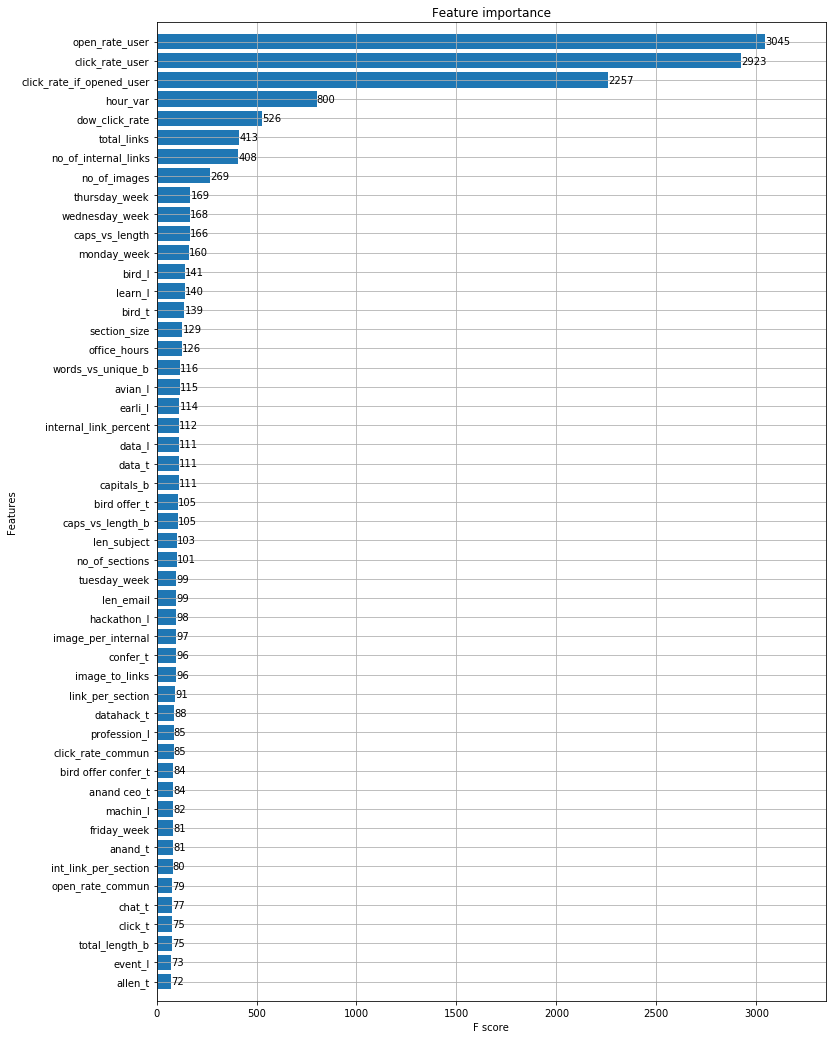

In [125]:
# feature_importances=pd.Series(model.feature_importances_,index=X_train.columns)
# feature_importances.sort_values(inplace=True,ascending=False)

# feature_importances
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [78]:
df_s=df_tn_isclick[['open_rate_user','click_rate_user','click_rate_if_opened_user','is_open','is_click']]
# .corr()

In [79]:
df_s.corr()

,open_rate_user,click_rate_user,click_rate_if_opened_user,is_open,is_click
open_rate_user,1.000000,0.364120,0.224189,0.623415,0.177897
click_rate_user,0.364120,1.000000,0.817620,0.226998,0.488566
click_rate_if_opened_user,0.224189,0.817620,1.000000,0.139763,0.399462
is_open,0.623415,0.226998,0.139763,1.000000,0.340833
is_click,0.177897,0.488566,0.399462,0.340833,1.000000


In [127]:
df_test1=df_test.copy()
df_test1['is_click']=y_pred_prob_test

In [128]:
sample_submission=df_test1[['id','is_click']]

In [129]:
sample_submission.to_csv('sample_submission5.csv',index=False)

In [67]:
df1=pd.DataFrame([[1,2,3],[5,6,7]],columns=['a','b','c'])
df2=pd.DataFrame([[11,12],[15,16]],columns=['b','a'])
df1['type']='train'
df2['type']='test'
df3=pd.concat([df1,df2])
df2_new=df3.loc[df3['type']=='test'].reset_index(drop=True)
df2_new

,a,b,c,type
0,12,11,NaN,test
1,16,15,NaN,test
